# Tutorial - Usage example liam - mosaic integration

## Install liam
Follow the installation instructions provided in the README.md of https://github.com/ohlerlab/liam_challenge_reproducibility to install liam. In the provided tutorial, we use a legacy version of liam (called 
liam_NeurIPS2021_challenge_reproducibility). For a version of liam under active development, see https://github.com/ohlerlab/liam. 

## Download example data 
Download the preprocessed data from the NeurIPS 2021 competition "Multimodal Single-Cell Data Integration" from GEO into a folder ```./../data/``` relative to the directory with this notebook (GEO accession: GSE194122; Supplementary file: comprises preprocessed data).

```
# Download data from GEO 
wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122%5Fopenproblems%5Fneurips2021%5Fmultiome%5FBMMC%5Fprocessed%2Eh5ad%2Egz

# Unzip file
zcat GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad.gz > GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad

```

As this data is paired- it contains simultaneously measured gene expression and chromatin accessibility measurements- we will modify the data later to simulate a mosaic integration scenario, where we only have some samples with paired measurements and unimodal data sets.

If you want to combine unimodal and multimodal data sets, you have to create "dummy" measurements for the missing modalities of the unimodal data sets by setting the entries of the respective data matrices (in X or obsm) to 0, with the number of features (e.g., genomic region) matching the ones of the paired data set.

We use field X of the AnnData object to store gene expression measurements. Chromatin accessibility measurements and cell surface protein measurements are stored in the obsm field of the AnnData object with a key of choice that you have to provide as a parameter to the setup_anndata function. 

## Set up tutorial environment

In [1]:
# Imports
import anndata as ad
import liam_NeurIPS2021_challenge_reproducibility
import scanpy as sc
import scvi
import torch

Global seed set to 0
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Check if GPU is available
print(torch.cuda.is_available())

True


In [4]:
# Set random seed to 0 (default) for reproducibility
scvi._settings.ScviConfig()

Global seed set to 0


## Specify model parameters
You can conveniently store all keyword arguments required for data loading and model training in a dictionary or specify the keyword arguments at the respective function call (see the vae.train() function call as an example, remove quotes around keyword arguments). Note how we make use of the scaling factor for the adversarial loss here ('factor_adversarial_loss').

In [5]:
# Setup model to param mapping (dictionary)
model = 'liam_BAVAE_NeurIPS_challenge_GEO_subset_mosaic_integration_upscaling_adversary'
model_param_mapping = {}
model_param_mapping[model] = {} 
# specify key to chromatin accessibility modality (key to obsm field of AnnData object)
# specify column name of metadata information used as batch key stored in the obs field of the AnnData object
model_param_mapping[model]['setup_anndata_params'] = {'chrom_acc_obsm_key': 'ATAC', 'batch_key': 'sample'}
# specify parameters for model training
model_param_mapping[model]['Liam_params'] = {'adversarial_training': True, 'n_latent': 20, 'factor_adversarial_loss': 5.0} 

## Load and setup data for liam
We use [AnnData](https://anndata.readthedocs.io/en/latest/) objects as input to our model. In particular, we store the gene expression modality in field X of the AnnData object and the chromatin accessibility modality with a key of our choice in the obsm field. Metadata should be stored in the field obs.

In [6]:
# Load GEO data
GEO_data = ad.read_h5ad('./../data/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

# Separate the GEX and ATAC data (data is concatenated in the provided AnnData obejct)
adata_mod1 = GEO_data[:,GEO_data.var['feature_types'] == 'GEX'].copy()
adata_mod2 = GEO_data[:,GEO_data.var['feature_types'] == 'ATAC'].copy()

# For a lightweight example, subset the data to only 20% of the full data set (random subsample)
adata_mod1 = adata_mod1[adata_mod1.obs.sample(frac=0.2, random_state=0).index].copy()
adata_mod2 = adata_mod2[adata_mod1.obs.index].copy()

# Subset the data to simulate a mosaic integration scenario - note that these subsetting operations require a lot of memory
# sites with a sample from donor 1 ("d1") measured: s1, s2, s4 
# s1 and s3: use only atac
adata_mod1.obs['mod'] = adata_mod1.obs['Site'].apply(lambda x: 'atac' if ((x == 'site1') | (x == 'site3')) else 'gex' if x == 'site2' else 'paired')
adata_mod1.layers["counts"][(adata_mod1.obs['Site'] == 'site1') | (adata_mod1.obs['Site'] == 'site3')] = 0
# s2: use only gex
adata_mod2.X[adata_mod2.obs['Site'] == 'site2'] = 0
# s4: keep paired data

# Setup adata object for liam
adata = adata_mod1.copy()

# Always check if your data is in csr format, this speeds up the training, if not, transform it 
# Use raw counts as GEX modality
adata.X = adata.layers['counts'].tocsr()
# Use binarized peak counts as ATAC modality, store it in the obsm field of the anndata object
# Use the same key to specify which data to use in the setup_anndata function 
adata.obsm['ATAC'] = adata_mod2.X.tocsr()

# Format metadata
adata.obs['sample'] = adata.obs['batch']
adata.obs['donor'] = adata.obs['batch'].apply(lambda x: x.split('d')[1])
adata.obs['site'] = adata.obs['batch'].apply(lambda x: x.split('d')[0])
adata.obs['cell type'] = adata_mod1.obs['cell_type']

# Remove intermediate data
del adata_mod1
del adata_mod2

##  Train model

In [7]:
# Set up input data
liam_NeurIPS2021_challenge_reproducibility.Liam.setup_anndata(
    adata, **model_param_mapping[model]['setup_anndata_params']
)

# Set up liam
vae = liam_NeurIPS2021_challenge_reproducibility.Liam(adata, **model_param_mapping[model]['Liam_params'])

# Train liam
vae.train(train_size=0.95, validation_size=0.05,
          batch_size=128, early_stopping=True, save_best=True, early_stopping_patience=10)


INFO     mypackage: Setting up anndata object using scVI for gene expression related         
         variables.                                                                          
INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 13850 cells, 13431 vars, 13       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     mypackage: Additionally setting up variables for chromatin accessibility related    
         variables.                                         

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using Liam train() method.
trainer_kwargs {}
Epoch 64/400:  16%|█▌        | 64/400 [32:09<2:48:48, 30.14s/it, loss=1.15e+04, v_num=1]


## Visualize learnt embedding

... storing 'mod' as categorical
... storing 'donor' as categorical
... storing 'site' as categorical


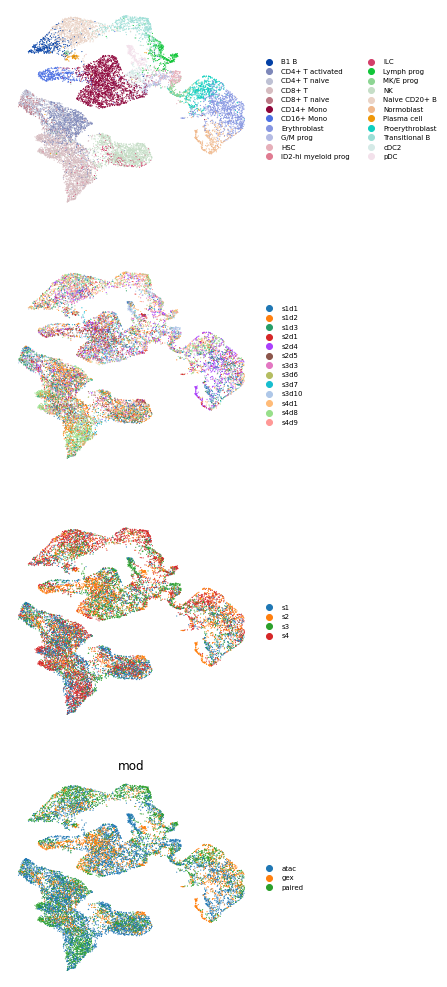

In [8]:
# Retrieve learnt embedding from the trained model
adata.obsm['embedding'] = vae.get_latent_representation()

# Compute nearest neighbors and UMAP representation of embedding
sc.pp.neighbors(adata, use_rep='embedding')
sc.tl.umap(adata)

# Visualize embedding with legend
sc.pl.umap(
        adata,
        color=['cell type', 'sample', 'site', 'mod'],
        size=5,
        frameon=False,
        ncols=1,
        wspace=-0.2,
        title=['','',''],
        legend_fontsize='x-small'
)

## Save the trained model

In [9]:
# Save trained model
vae.save('{}'.format(model), save_anndata=True)